Bismillahir Rahmaanir Raheem <br>
Almadadh Ya Gause Radi Allahu Ta'alah Anh - Ameen

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Relevant Libraries

In [ ]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import csv
import itertools
import collections

import pywt
from scipy import stats

from sklearn.utils import resample
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Conv1D, AvgPool1D, Flatten, Dense, Dropout, Softmax
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras import regularizers


%matplotlib inline

# Matplotlib Setup

In [ ]:
plt.rcParams["figure.figsize"] = (30,6)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True

# Define Relevant Functions

In [ ]:
# Define denoising function
def denoise(data):
    # Apply Symlet wavelet to remove noise from the ECG signals
    w = pywt.Wavelet('sym4')
    maxlev = pywt.dwt_max_level(len(data), w.dec_len)
    threshold = 0.04 # Threshold for filtering

    coeffs = pywt.wavedec(data, 'sym4', level=maxlev)
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))

    datarec = pywt.waverec(coeffs, 'sym4')

    return datarec

# Define Variables

In [ ]:
path = "/content/drive/My Drive/mitbih_database/"
window_size = 180
maximum_counting = 10000

classes = ['N', 'L', 'R', 'A', 'V']
n_classes = len(classes)
count_classes = [0]*n_classes

X = list()
y = list()

# Prepare Input Files

In [ ]:
# Read files
filenames = next(os.walk(path))[2]

# Split and save .csv , .txt
records = list()
annotations = list()
filenames.sort()

# Prepare input files

In [ ]:
# Read files
filenames = next(os.walk(path))[2]

# Split and save .csv , .txt
records = list()
annotations = list()
filenames.sort()

In [ ]:
# filenames and annotations
for f in filenames:
    filename, file_extension = os.path.splitext(f)

    # *.csv
    if(file_extension == '.csv'):
        records.append(path + filename + file_extension)

    # *.txt
    else:
        annotations.append(path + filename + file_extension)

# Data Extraction and Pre-processing

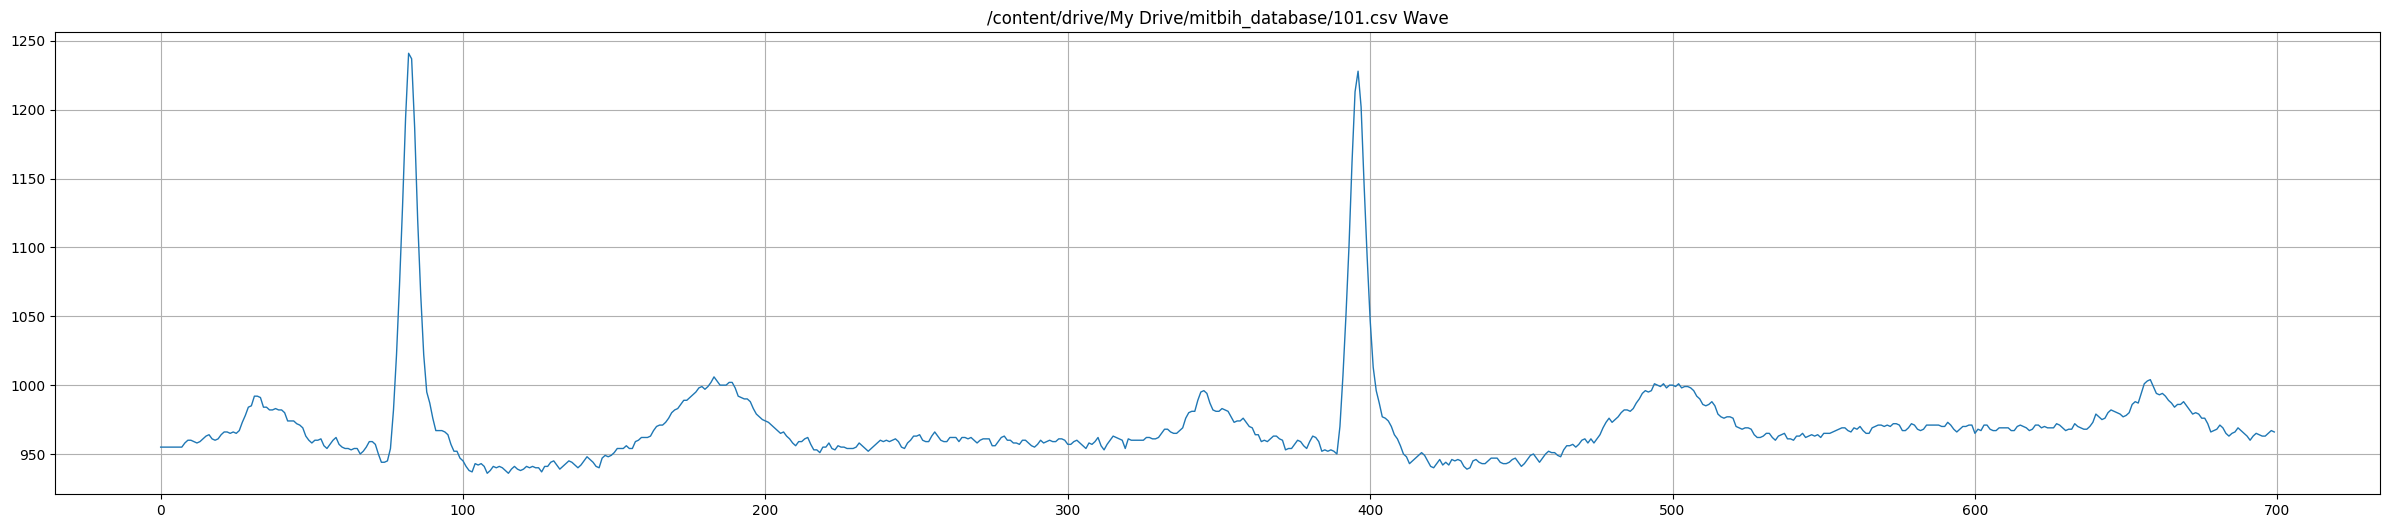

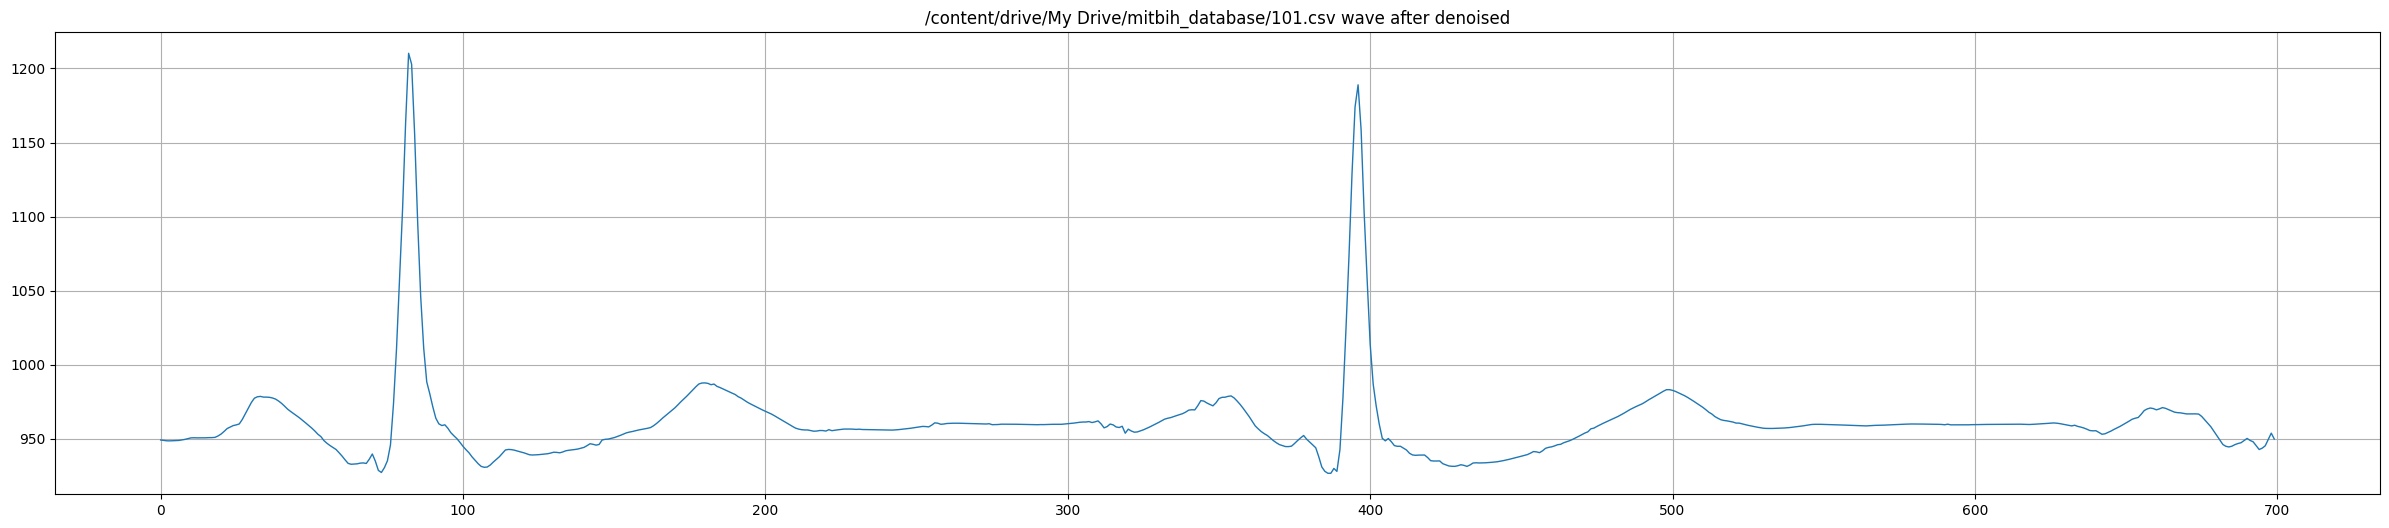

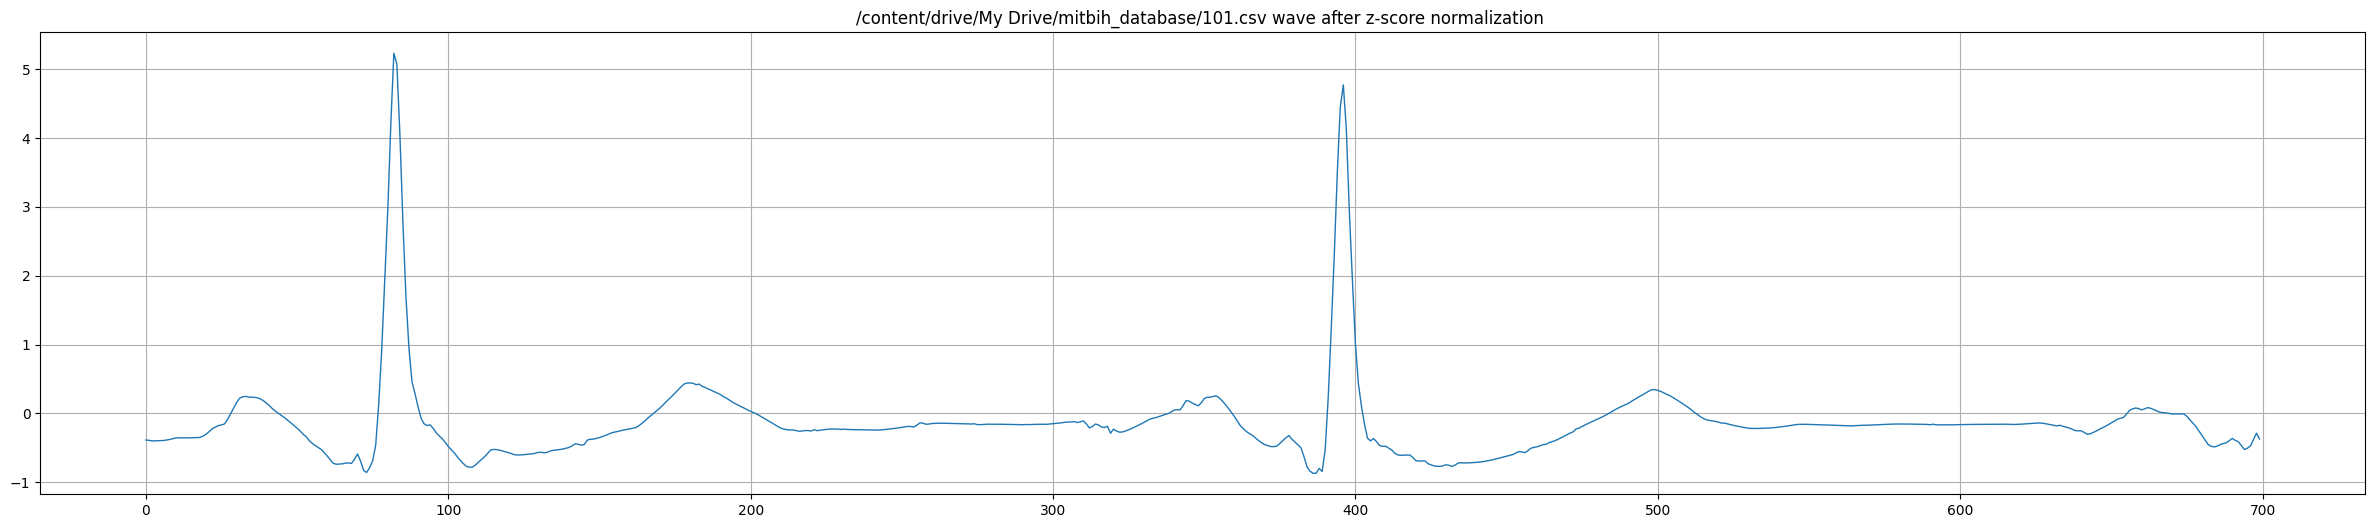

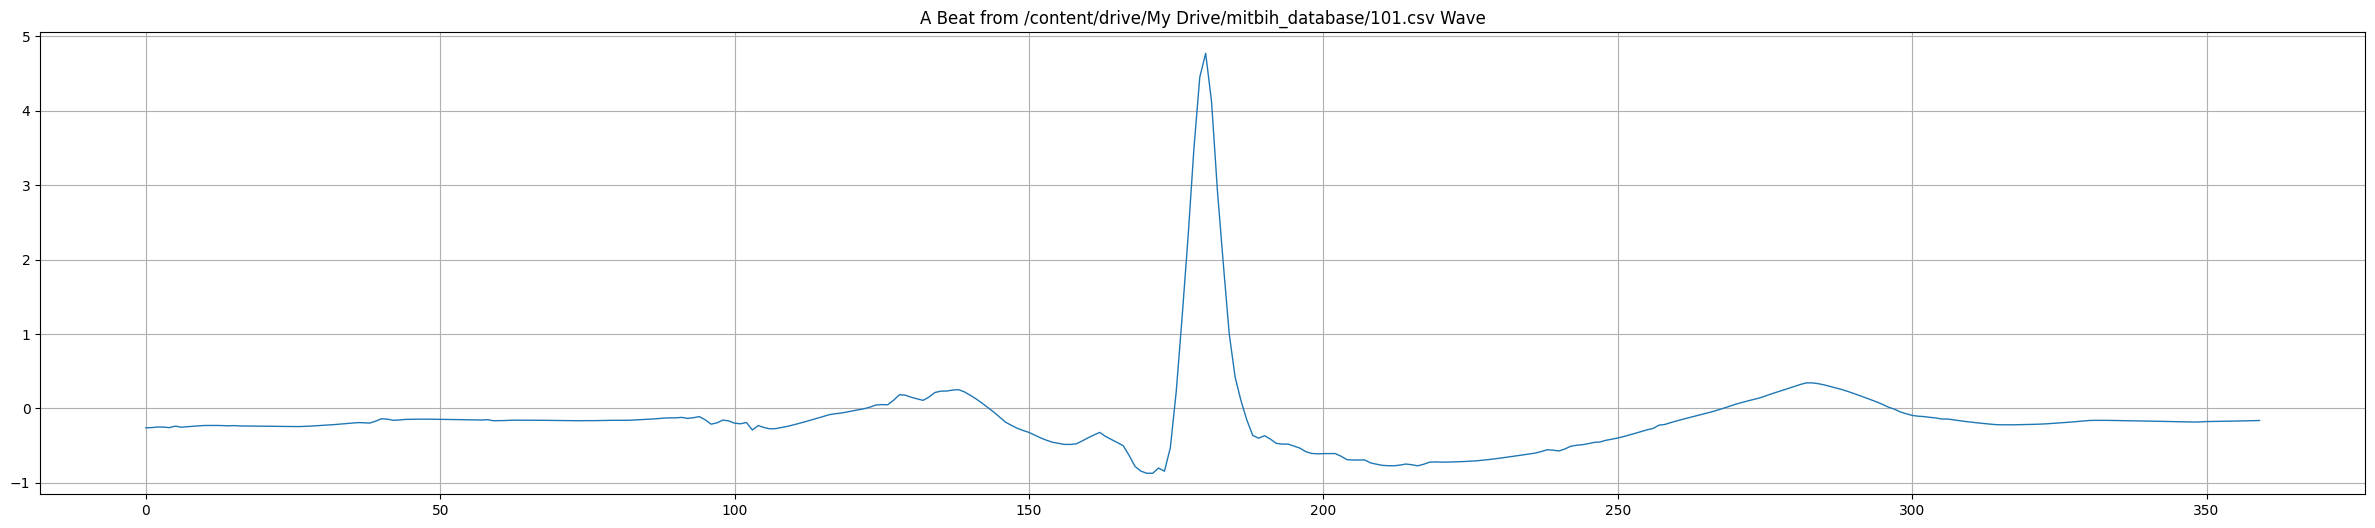

(100012, 360) (100012,)


In [ ]:
# Records
for r in range(0,len(records)):
    signals = []

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') # read CSV file
        row_index = -1
        for row in spamreader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1

    # Plot an example to the signals
    if r == 1:
        # Plot each patient's signal
        plt.title(records[1] + " Wave")
        plt.plot(signals[0:700])
        plt.show()

    signals = denoise(signals)
    # Plot an example to the signals
    if r == 1:
        # Plot each patient's signal
        plt.title(records[1] + " wave after denoised")
        plt.plot(signals[0:700])
        plt.show()

    signals = stats.zscore(signals)
    # Plot an example to the signals
    if r == 1:
        # Plot each patient's signal
        plt.title(records[1] + " wave after z-score normalization ")
        plt.plot(signals[0:700])
        plt.show()

    # Read annotations: R position and Arrhythmia class
    example_beat_printed = False
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines()
        beat = list()

        for d in range(1, len(data)): # 0 index is Chart Head
            splitted = data[d].split(' ')
            splitted = filter(None, splitted)
            next(splitted) # Time... Clipping
            pos = int(next(splitted)) # Sample ID
            arrhythmia_type = next(splitted) # Type
            if(arrhythmia_type in classes):
                arrhythmia_index = classes.index(arrhythmia_type)
#                 if count_classes[arrhythmia_index] > maximum_counting: # avoid overfitting
#                     pass
#                 else:
                count_classes[arrhythmia_index] += 1
                if(window_size <= pos and pos < (len(signals) - window_size)):
                    beat = signals[pos-window_size:pos+window_size]     ## REPLACE WITH R-PEAK DETECTION
                    # Plot an example to a beat
                    if r == 1 and not example_beat_printed:
                        plt.title("A Beat from " + records[1] + " Wave")
                        plt.plot(beat)
                        plt.show()
                        example_beat_printed = True

                    X.append(beat)
                    y.append(arrhythmia_index)
# data shape
print(np.shape(X), np.shape(y))

In [ ]:
for i in range(0,len(X)):
        X[i] = np.append(X[i], y[i])
#         X[i].append(y[i])

print(np.shape(X))

(100012, 361)


# Class Distribution before Resampling

In [ ]:
X_train_df = pd.DataFrame(X)

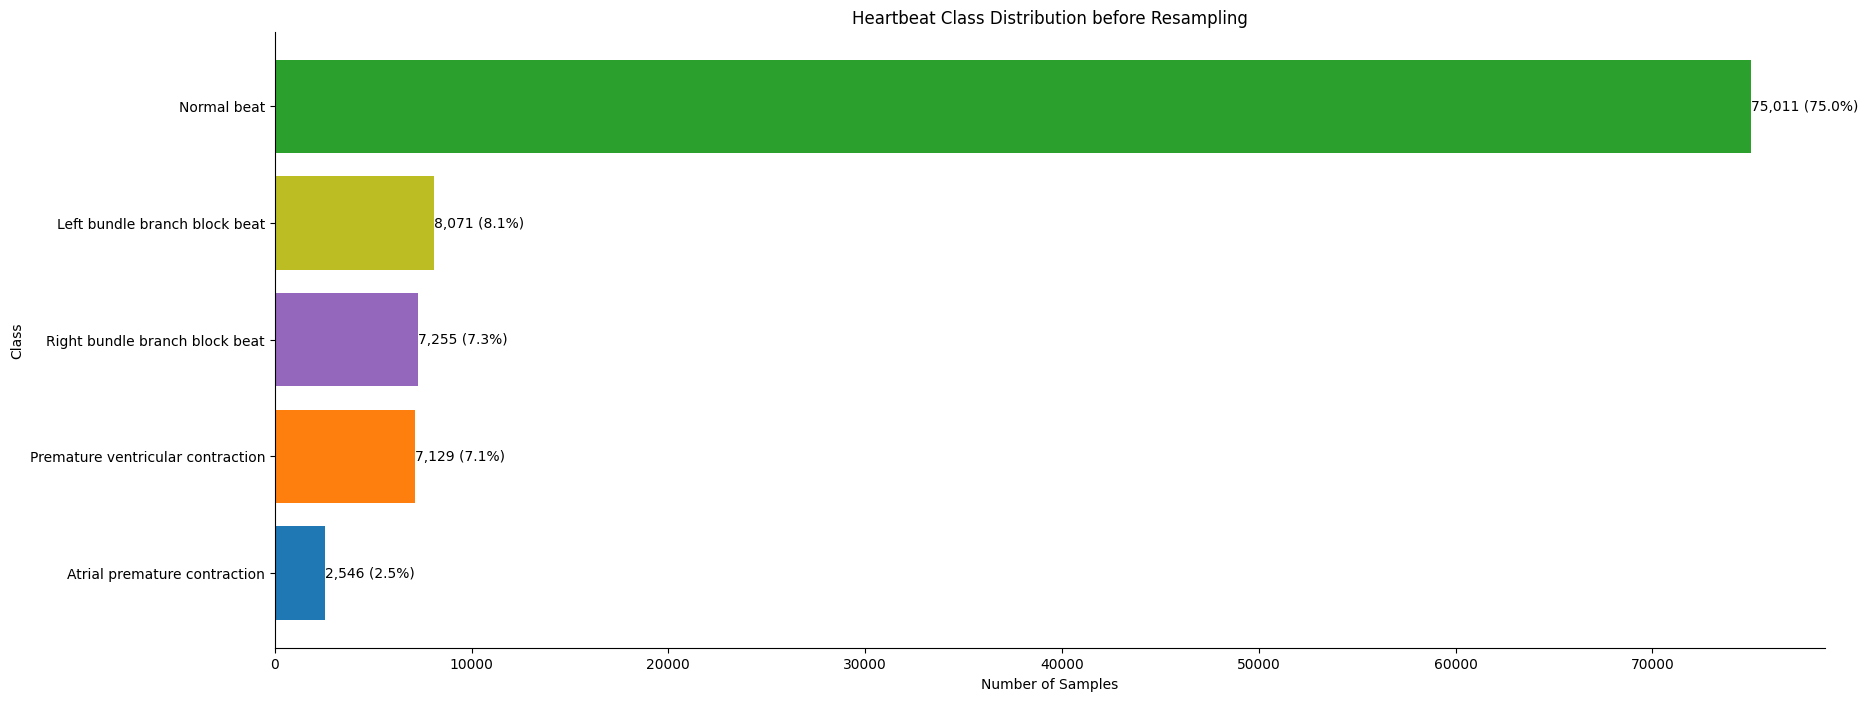

In [ ]:
# Class Distribution
# X_train_df = pd.DataFrame(X)
per_class = X_train_df[X_train_df.shape[1]-1].value_counts().sort_values(ascending=True)

# create a mapping for the labels
label_mapping = {0.0:'Normal beat', 1.0:'Left bundle branch block beat', 2.0:'Right bundle branch block beat', 3.0:'Atrial premature contraction', 4.0:'Premature ventricular contraction'}
labels = [label_mapping[i] for i in per_class.index]
counts = per_class.values
total_count = sum(counts)

fig, ax = plt.subplots(figsize=(20,8))  # increased figure size
plt.grid(False)  # remove grid lines
bars = plt.barh(labels, counts, color=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'])

# removing the top and right border
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# adding the counts and percentages on the bars
for bar in bars:
    width = bar.get_width()
    percentage = f'({width/total_count * 100:.1f}%)'  # calculate percentage
    plt.text(width, bar.get_y() + bar.get_height()/2, f'{width:,.0f} {percentage}', va='center')

plt.title("Heartbeat Class Distribution before Resampling")
plt.xlabel("Number of Samples")
plt.ylabel("Class")
plt.show()


0.0    75011
1.0     8071
2.0     7255
4.0     7129
3.0     2546
Name: 360, dtype: int64


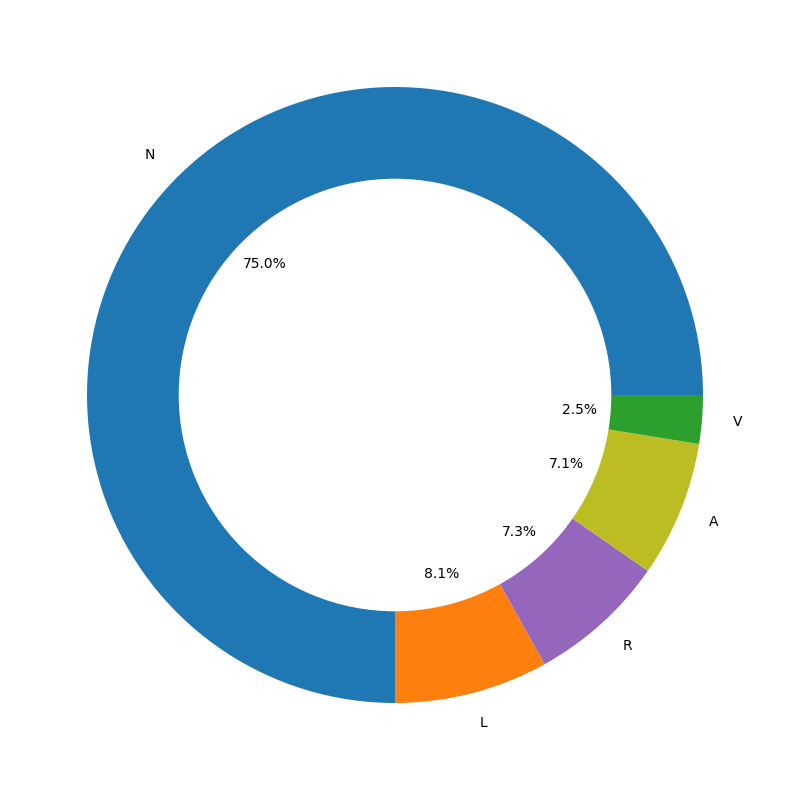

In [ ]:
# Pie chart
# X_train_df = pd.DataFrame(X)
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

# Class Balancing

In [ ]:
df_1=X_train_df[X_train_df[X_train_df.shape[1]-1]==1]
df_2=X_train_df[X_train_df[X_train_df.shape[1]-1]==2]
df_3=X_train_df[X_train_df[X_train_df.shape[1]-1]==3]
df_4=X_train_df[X_train_df[X_train_df.shape[1]-1]==4]
# df_5=X_train_df[X_train_df[X_train_df.shape[1]-1]==5]
df_0=(X_train_df[X_train_df[X_train_df.shape[1]-1]==0]).sample(n=5000,random_state=42)

In [ ]:
df_1_upsample=resample(df_1,replace=True,n_samples=5000,random_state=122)
df_2_upsample=resample(df_2,replace=True,n_samples=5000,random_state=123)
df_3_upsample=resample(df_3,replace=True,n_samples=5000,random_state=124)
df_4_upsample=resample(df_4,replace=True,n_samples=5000,random_state=125)
# df_5_upsample=resample(df_5,replace=True,n_samples=5000,random_state=126)

In [ ]:
# X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample,df_5_upsample])
X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

# Class Distribution after Resampling

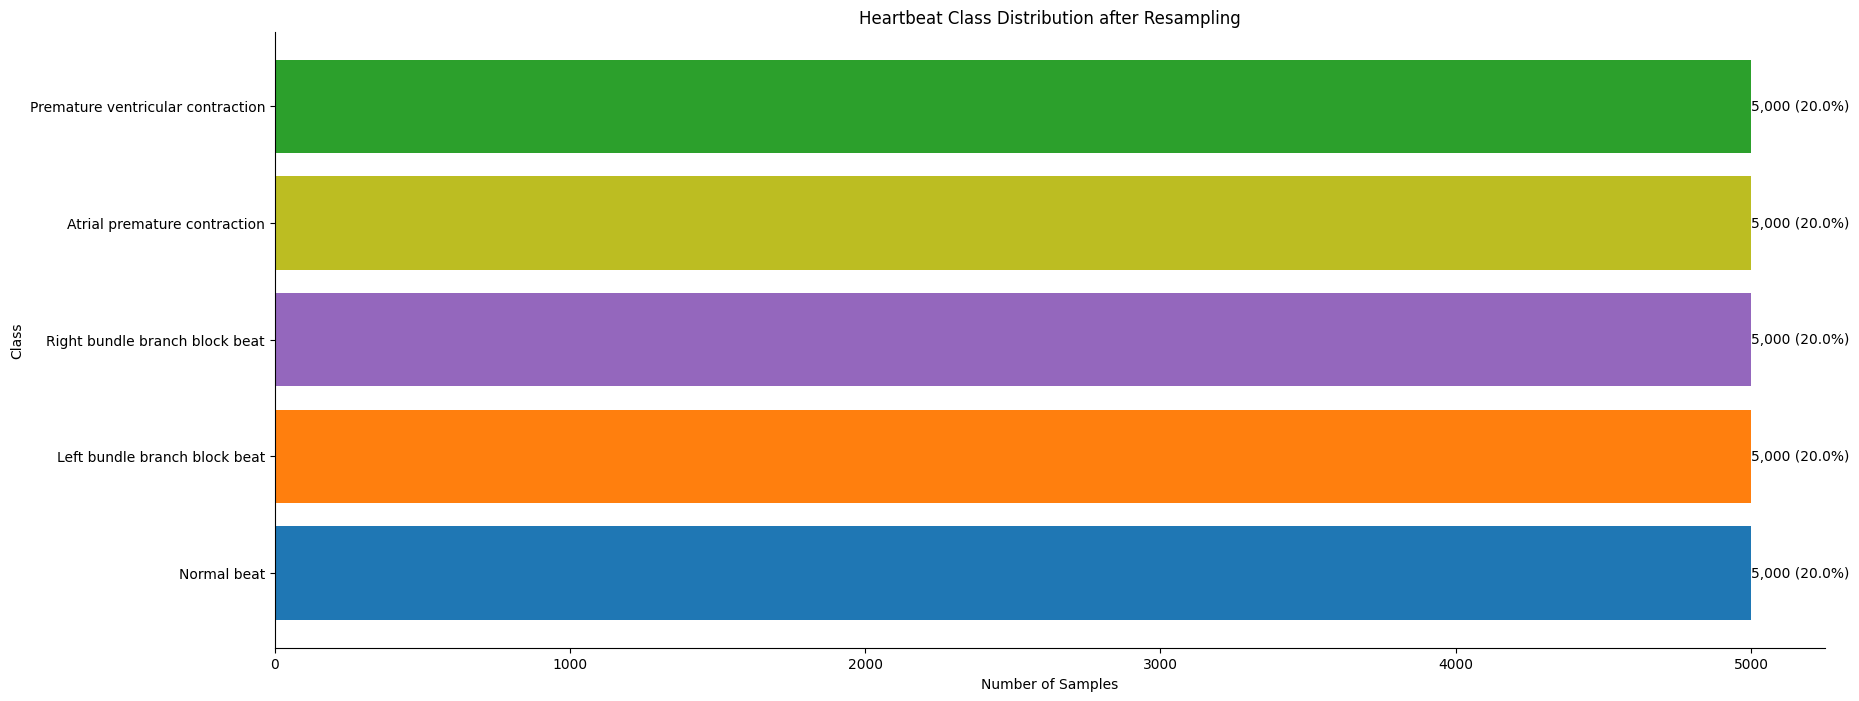

In [ ]:
# Class Distribution
# X_train_df = pd.DataFrame(X)
per_class = X_train_df[X_train_df.shape[1]-1].value_counts().sort_values(ascending=True)

# create a mapping for the labels
label_mapping = {0.0:'Normal beat', 1.0:'Left bundle branch block beat', 2.0:'Right bundle branch block beat', 3.0:'Atrial premature contraction', 4.0:'Premature ventricular contraction'}
labels = [label_mapping[i] for i in per_class.index]
counts = per_class.values
total_count = sum(counts)

fig, ax = plt.subplots(figsize=(20,8))  # increased figure size
plt.grid(False)  # remove grid lines
bars = plt.barh(labels, counts, color=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'])

# removing the top and right border
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# adding the counts and percentages on the bars
for bar in bars:
    width = bar.get_width()
    percentage = f'({width/total_count * 100:.1f}%)'  # calculate percentage
    plt.text(width, bar.get_y() + bar.get_height()/2, f'{width:,.0f} {percentage}', va='center')

plt.title("Heartbeat Class Distribution after Resampling")
plt.xlabel("Number of Samples")
plt.ylabel("Class")
plt.show()


0.0    5000
1.0    5000
2.0    5000
3.0    5000
4.0    5000
Name: 360, dtype: int64


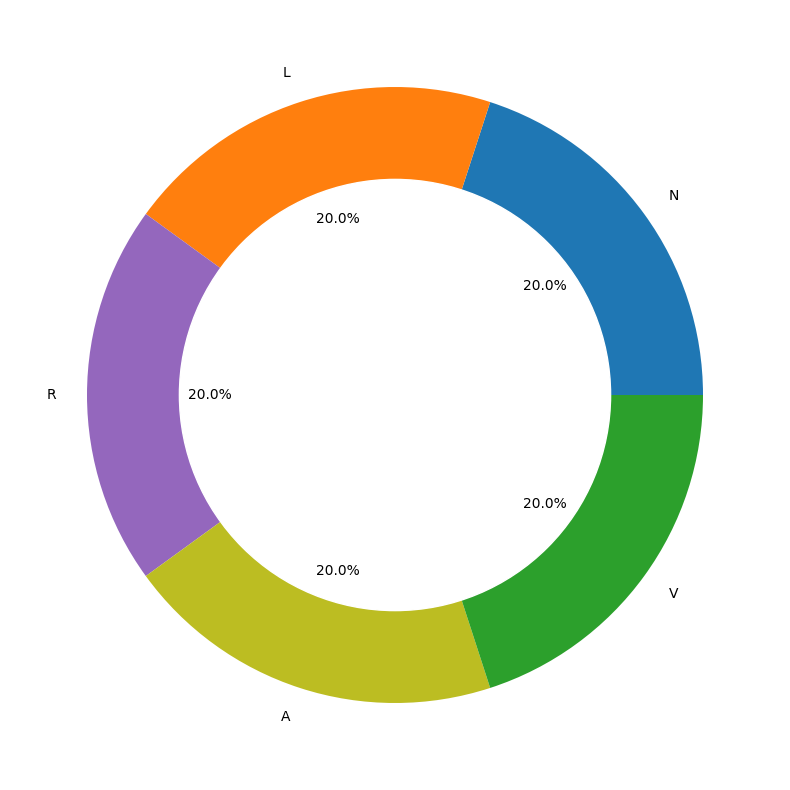

In [ ]:
# Pie chart
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

# Train-Test Split

In [ ]:
train, test = train_test_split(X_train_df, test_size=0.20)

print("X_train : ", np.shape(train))
print("X_test  : ", np.shape(test))

X_train :  (20000, 361)
X_test  :  (5000, 361)


In [ ]:
target_train=train[train.shape[1]-1]
target_test=test[test.shape[1]-1]
train_y=to_categorical(target_train)
test_y=to_categorical(target_test)
print(np.shape(train_y), np.shape(test_y))

(20000, 5) (5000, 5)


In [ ]:
train_x = train.iloc[:,:train.shape[1]-1].values
test_x = test.iloc[:,:test.shape[1]-1].values
train_x = train_x.reshape(len(train_x), train_x.shape[1],1)
test_x = test_x.reshape(len(test_x), test_x.shape[1],1)
print(np.shape(train_x), np.shape(test_x))

(20000, 360, 1) (5000, 360, 1)


# Building a Convolutional Neural Network (CNN) Model

In [ ]:
# Instantiate an empty model
model = Sequential()

# Adding a Convolution Layer C1
# Input shape = N = (360 x 1)
# No. of filters  = 16
# Filter size = f = (13 x 1)
# Padding = true
# Strides = S = 1
# Size of each feature map in C1 is (N-f+2P)/S +1 = 360-13+2*6 +1 = 360
# No. of parameters between input layer and C1 = (13*1 + 1)*16 = 224
model.add(Conv1D(filters=16, kernel_size=13, padding='same', activation='relu',input_shape=(360, 1)))


# Adding an Average Pooling Layer S2
# Input shape = N = (360 x 16)
# No. of filters = 16
# Filter size = f = (3 x 1)
# Padding = P = 0
# Strides = S = 2
# Size of each feature map in S2 is (N-f+2P+1)/S = (360-3+0+1)/2 = 179
# No. of parameters between C1 and S2 = (1+1)*16 = 32
model.add(AvgPool1D(pool_size=3, strides=2))





# Adding a Convolution Layer C3
# Input shape = N = (179 x 16)
# No. of filters  = 32
# Filter size = f = (15 x 1)
# Padding = true
# Strides = S = 1
# Size of each feature map in C1 is (N-f+2P)/S +1 = 179-15+2*7 +1 = 360
# No. of parameters between input layer and C1 = (15*1 + 1)*32 = 512
model.add(Conv1D(filters=32, kernel_size=15, padding='same', activation='relu'))


# Adding an Average Pooling Layer S4
# Input shape = N = (179 x 32)
# No. of filters = 32
# Filter size = f = (3 x 1)
# Padding = P = 0
# Strides = S = 2
# Size of each feature map in S2 is (N-f+2P+1)/S = (179-3+0+1)/2 = 89
# No. of parameters between C1 and S2 = (1+1)*32 = 64
model.add(AvgPool1D(pool_size=3, strides=2))



# Adding a Convolution Layer C5
# Input shape = N = (89 x 32)
# No. of filters  = 64
# Filter size = f = (17 x 1)
# Padding = true
# Strides = S = 1
# Size of each feature map in C1 is (N-f+2P)/S +1 = 89-17+2*8 +1 = 89
# No. of parameters between input layer and C1 = (17*1 + 1)*64 = 1152
model.add(Conv1D(filters=64, kernel_size=17, padding='same', activation='relu'))



# Adding an Average Pooling Layer S6
# Input shape = N = (89 x 64)
# No. of filters = 64
# Filter size = f = (3 x 1)
# Padding = P = 0
# Strides = S = 2
# Size of each feature map in S2 is (N-f+2P+1)/S = (89-3+0+1)/2 = 44
# No. of parameters between C1 and S2 = (1+1)*64 = 128
model.add(AvgPool1D(pool_size=3, strides=2))



# Adding a Convolution Layer C7
# Input shape = N = (44 x 64)
# No. of filters  = 128
# Filter size = f = (19 x 1)
# Padding = true
# Strides = S = 1
# Size of each feature map in C1 is (N-f+2P)/S +1 = 44-19+2*9 +1 = 44
# No. of parameters between input layer and C1 = (19*1 + 1)*128 = 2560
model.add(Conv1D(filters=128, kernel_size=19, padding='same', activation='relu'))


# Adding an Average Pooling Layer S8
# Input shape = N = (44 x 128)
# No. of filters = 128
# Filter size = f = (3 x 1)
# Padding = P = 0
# Strides = S = 2
# Size of each feature map in S2 is (N-f+2P+1)/S = (44-3+0+1)/2 = 21
# No. of parameters between C1 and S2 = (1+1)*128 = 256
model.add(AvgPool1D(pool_size=3, strides=2))



# Flattening the layer
# There would be 128*(21*1) = 2688 neurons
model.add(Flatten())


# Dropout the layer S9
model.add(Dropout(0.5))



# Adding a Dense layer with regularization l2(0.0001)# S10
# No. of inputs = 2688
# No. of outputs = 35
# No. of parameters = 2688 x 35 + 35 = 94115
model.add(Dense(35,kernel_regularizer=regularizers.l2(0.0001), bias_regularizer=regularizers.l2(0.0001)))



# Adding a Dense layer with regularization l2(0.0001)# S11
# No. of inputs = 35
# No. of outputs = 5
# No. of parameters = 35*5 + 5 = 180
model.add(Dense(5,kernel_regularizer=regularizers.l2(0.0001), bias_regularizer=regularizers.l2(0.0001)))



# Adding a Softmax layer S12
# No. of inputs = 5
# No. of outputs = 5
model.add(Softmax())


model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 360, 16)           224       
                                                                 
 average_pooling1d_4 (Averag  (None, 179, 16)          0         
 ePooling1D)                                                     
                                                                 
 conv1d_5 (Conv1D)           (None, 179, 32)           7712      
                                                                 
 average_pooling1d_5 (Averag  (None, 89, 32)           0         
 ePooling1D)                                                     
                                                                 
 conv1d_6 (Conv1D)           (None, 89, 64)            34880     
                                                                 
 average_pooling1d_6 (Averag  (None, 44, 64)          

# Compile the CNN Model

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Train the CNN Model

In [ ]:
history = model.fit(train_x, train_y, batch_size=36, epochs=60, verbose=1, validation_split=0.2) # epoch = 10, batch_size = 32

Epoch 1/60
445/445 [==============================] - 4s 7ms/step - loss: 0.3765 - accuracy: 0.8726 - val_loss: 0.1778 - val_accuracy: 0.9455
Epoch 2/60
445/445 [==============================] - 2s 5ms/step - loss: 0.1582 - accuracy: 0.9499 - val_loss: 0.1303 - val_accuracy: 0.9588
Epoch 3/60
445/445 [==============================] - 2s 5ms/step - loss: 0.1216 - accuracy: 0.9637 - val_loss: 0.1116 - val_accuracy: 0.9645
Epoch 4/60
445/445 [==============================] - 2s 5ms/step - loss: 0.1066 - accuracy: 0.9678 - val_loss: 0.1261 - val_accuracy: 0.9610
Epoch 5/60
445/445 [==============================] - 3s 6ms/step - loss: 0.0894 - accuracy: 0.9751 - val_loss: 0.0968 - val_accuracy: 0.9725
Epoch 6/60
445/445 [==============================] - 3s 6ms/step - loss: 0.0762 - accuracy: 0.9801 - val_loss: 0.1189 - val_accuracy: 0.9685
Epoch 7/60
445/445 [==============================] - 2s 5ms/step - loss: 0.0727 - accuracy: 0.9807 - val_loss: 0.0818 - val_accuracy: 0.9778
Epoch 

# Plot the Loss of the CNN Model

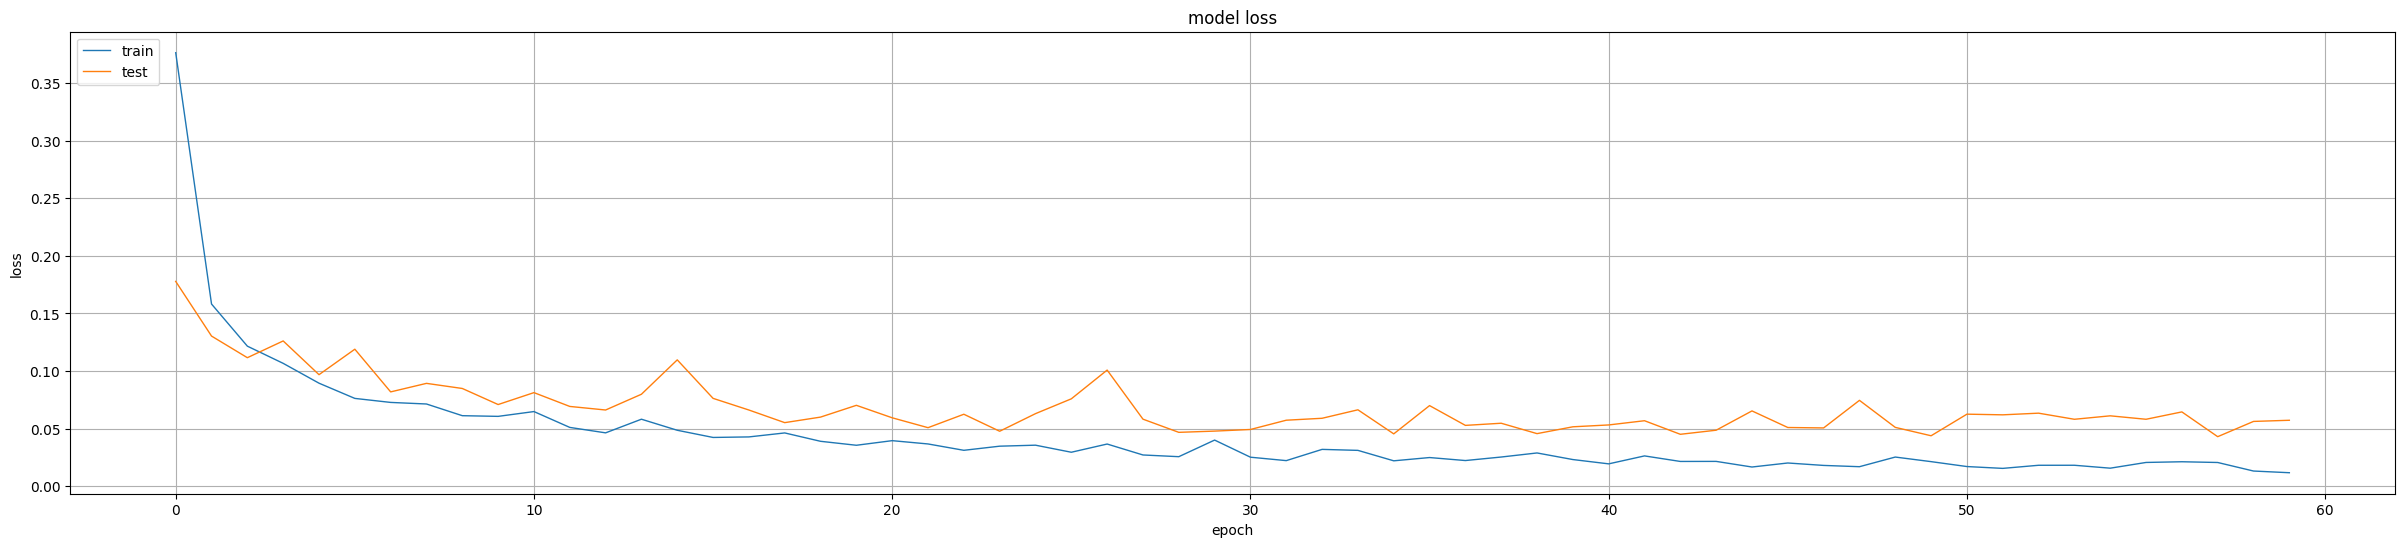

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
# plt.grid(False)  # remove grid lines
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Plot the Accuracy of the CNN Model

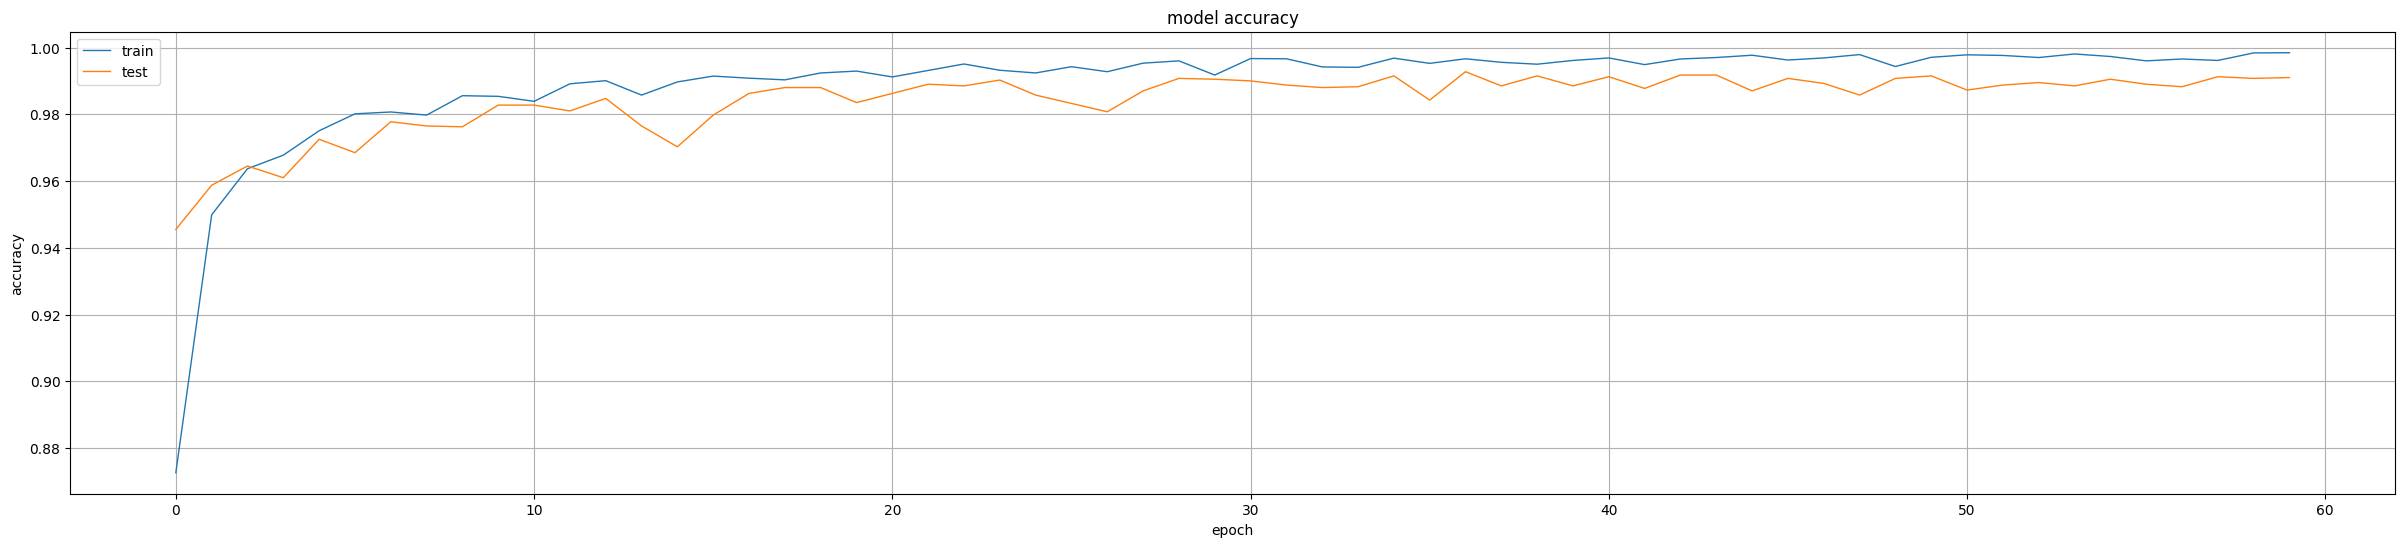

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
# plt.grid(False)  # remove grid lines
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Loss and Accuracy of the CNN Model

In [ ]:
score = model.evaluate(test_x, test_y)

print('Test Loss:', score[0])
print('Test accuracy:', score[1])

157/157 [==============================] - 1s 4ms/step - loss: 0.0894 - accuracy: 0.9900
Test Loss: 0.08935488760471344
Test accuracy: 0.9900000095367432


# CNN Model Predictions

157/157 [==============================] - 0s 2ms/step
[[ 961    0    1   19    4]
 [   1 1015    0    0    1]
 [   1    0  976    1    0]
 [   8    0    1 1009    0]
 [   8    1    0    4  989]]


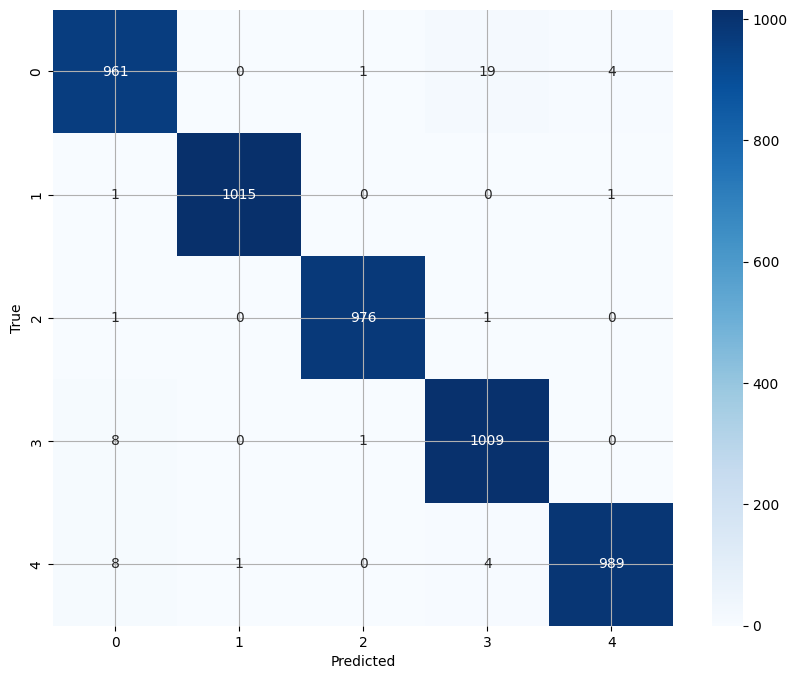

Accuracy: 0.99
PPV: 0.99
Sensitivity: 0.99
F1 Score: 0.99
FPR: 0.01


In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import seaborn as sns


y_pred = model.predict(test_x)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_y, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print(conf_matrix)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Accuracy
accuracy = accuracy_score(y_true, y_pred_classes)
print(f"Accuracy: {accuracy:.2f}")

# Precision (PPV)
precision = precision_score(y_true, y_pred_classes, average='macro')
print(f"PPV: {precision:.2f}")

# Recall (Sensitivity)
recall = recall_score(y_true, y_pred_classes, average='macro')
print(f"Sensitivity: {recall:.2f}")

# F1 Score
f1 = f1_score(y_true, y_pred_classes, average='macro')
print(f"F1 Score: {f1:.2f}")

# False Positive Rate (FPR)
FPR = 1 - precision
print(f"FPR: {FPR:.2f}")


# Save the CNN Model

In [ ]:
model.save("model.h5") # Hierarchical Data Format (HDF5) file format - commonly used for saving Keras models.

# Load the CNN Model

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('model.h5')

# CNN Model Intepretability

In [ ]:
!pip install shap

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


TypeError: ignored

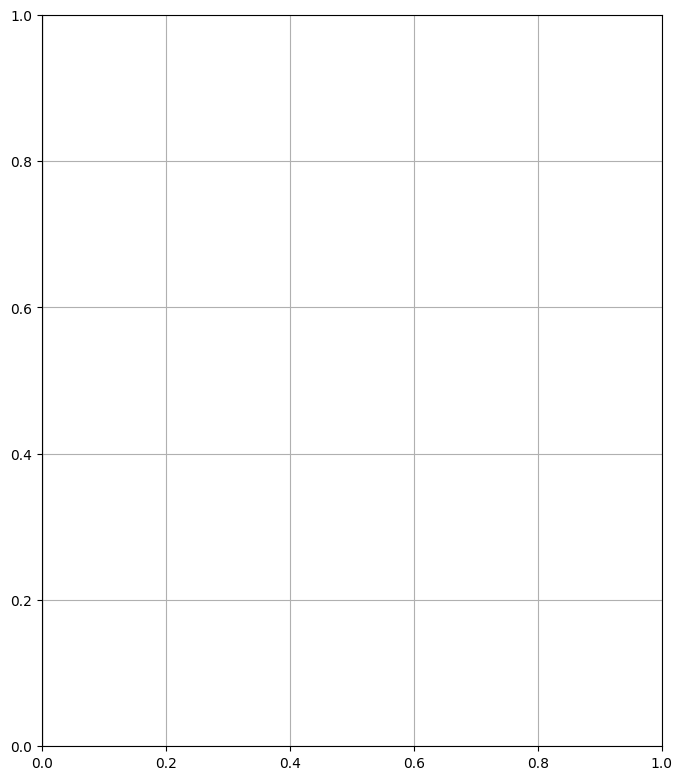

In [ ]:
import shap
import numpy as np

# Select a set of background examples to take an expectation over
background = train_x[np.random.choice(train_x.shape[0], 100, replace=False)]

# Explain predictions of the model
explainer = shap.DeepExplainer(model, background)
shap_values = explainer.shap_values(test_x)

# Make sure shap_values is a list of 2D numpy arrays
shap_values = [np.array(vals) for vals in shap_values]

# Convert test_x to a 2D numpy array if it is not already
test_x_arr = np.array(test_x).reshape((len(test_x), -1))

# Plot the feature attributions
shap.summary_plot(shap_values, test_x_arr)
